# Procesamiento de la información

In [ ]:
! jupyter nbconvert --to html 3_Procesamiento_infomación.ipynb

[NbConvertApp] Converting notebook 3_Procesamiento_infomación.ipynb to html
[NbConvertApp] Writing 894179 bytes to 3_Procesamiento_infomación.html


In [ ]:
import missingno as msno
import pickle 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from typing import Tuple

from typing import List, Dict

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'
from IPython.display import display

import os
import sys

# Agregar mi librería personalizada de python
module_path = os.path.abspath(os.path.join(os.getcwd().replace('notebooks', 'src')))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import rain
import importlib

def reload():
    """" Used to reload the modules"""
    libs_list = [rain]
    for lib in libs_list:
        importlib.reload(lib)

    print("Reload complete")

## Objetivo del notebook

En este notebook, se realizarán los siguiente tratamientos:
1. Procesamiento de la fecha
2. Partición de la información: entrenamiento y prueba
3. Manejo de datos faltantes
4. Remoción de multicolinearidad
5. Remoción de valores atípicos
6. Transformación de las características

In [ ]:
file = r'..\data\weatherAUS.csv'
# Leyendo el dataset
df = rain.read_weather(file)

## 1. Procesamiento de la fecha

Las lluvias son ciclicas, por lo que es buena idea realizar un manejo de la fechas para ser usadas más adelante, lo cual, pude hacerse a través de la transformación mediante seno y coseno.

In [ ]:
def encode_sin_cos(data: pd.DataFrame, col, max_val) -> pd.DataFrame:
	"""Transform the values using sinus and cosine to convert the values
	to a cyclical values"""
	data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
	data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
	return data

df = rain.encode_sin_cos(df, 'month', 12)

In [ ]:
def pipline_read_data(path: str) -> pd.DataFrame:
    """Returns the Australia Weather dataframme with some preprocess:
	dropping rows with missing data in the target attribute 'RainTomorrow',
	and encoding the month with the sinus and cosine transformations"""
    df = rain.read_weather(path)
    df = df.dropna(subset = ['RainTomorrow'])
    df = encode_sin_cos(df, 'month', 12)
    
    return df

## 2. Partición de la información

Antes de continuar con el procesamiento de la información, es importante dividirla en train y test, debido a que se supone que aún "no contamos" con los datos de prueba, por eso es una buena práctica, realizar la división de la información desde el inicio, para que no se vean afectadas métricas como promedio, valores atípicos, entre otros. <br>

Realizaré una división de 75% - 25% además de usar un muestreo estratificado, para mantener la proporción del atributo a clasificar.

In [ ]:
df = rain.pipline_read_data(file)

In [ ]:
def split_data(data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
	"""Splits the data in train and test, with a proportion of 0.75 (train)
	 and 0.25 (test) in a stratify form """

	df_train, df_test = train_test_split(data,
	                                     train_size=0.75, random_state=1,
	                                     stratify=data['RainTomorrow'])

In [ ]:
# Particionando la información en train y test
df_train, _ = rain.split_data(df)

In [ ]:
df_train.shape

(106644, 27)

In [ ]:
df_test.shape

(35549, 27)

## 3. Imputación de datos

En el segundo notebook, observamos que los atributos: 'Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am' contienen una gran cantidad de datos faltantes (>35%) además que se han incrementado con el tiempo. Por ello, propongo que sean elminados en uno de los modelos y comparar su valor predictivo, por ahora se análizaran como todos los demás datos.

In [ ]:
df = rain.pipline_read_data(file)
df_train, _ = rain.split_data(df)

### Categóricos

In [ ]:
def get_categorical_columns(data: pd.DataFrame) -> list:
    """Returns a list with the names of the columns that are object types"""
    return data.select_dtypes('object').columns[:-1].to_list()

In [ ]:
# Seleccionando todos las columnas de tipo object, excepto Location and RainTomorrow
categorical_cols = rain.get_categorical_columns(df_train)
categorical_cols

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

Sabemos que el atributo locación no tiene datos nulos, por lo que procederemos a crear un diccionario con la moda para los atributos categóricos, para ser usados posteriormente en el dataset de prueba

In [ ]:
def get_mode(series: pd.Series) -> object:
    """Return the mode for a dataset"""
    return series.mode()[0]

In [ ]:
def create_dictionary_mode(data: pd.DataFrame, columns: list[str, ...]) -> Dict:
    """Returns a dictionarty with the mode for every column in a dataframe"""
    return {col: get_mode(data[col]) for col in columns}  

In [ ]:
mode_dict = rain.create_dictionary_mode(df_train, categorical_cols)

In [ ]:
mode_dict

{'Location': 'Canberra',
 'WindGustDir': 'W',
 'WindDir9am': 'N',
 'WindDir3pm': 'SE',
 'RainToday': 'No'}

In [ ]:
# Salvando en un archivo pickle para ser usado posteriormente
def save_to_pickle(obj: object, path: str) -> None:
    with open(path + '.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_pickle(path: str) -> any:
	with open(path, 'rb') as file:
		object_file = pickle.load(file)
	return object_file

In [ ]:
save_to_pickle(mode_dict, '../results/mode_dict')

In [ ]:
mode_dict = rain.load_pickle('../results/mode_dict.pickle')
mode_dict

{'Location': 'Canberra',
 'WindGustDir': 'W',
 'WindDir9am': 'N',
 'WindDir3pm': 'SE',
 'RainToday': 'No'}

In [ ]:
# Imputando con la moda en el conjunto de datos train y test
for col in categorical_cols:
    df_train[col].fillna(mode_dict[col], inplace=True)

### Númericos

In [ ]:
def get_numerical_columns(data: pd.DataFrame) -> list:
    return data.select_dtypes('float64').columns.to_list()

In [ ]:
# Seleccionando todos las columnas de tipo object, excepto Location and RainTomorrow
numerical_cols = rain.get_numerical_columns(df_train)
numerical_cols

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'month_sin',
 'month_cos']

In [ ]:
def get_median(series: pd.Series) -> float:
	return round(series.median(), 2)

In [ ]:
median_dict = rain.create_dictionary_median(df_train, numerical_cols)

In [ ]:
median_dict

{'MinTemp': 12.0,
 'MaxTemp': 22.7,
 'Rainfall': 0.0,
 'Evaporation': 4.8,
 'Sunshine': 8.5,
 'WindGustSpeed': 39.0,
 'WindSpeed9am': 13.0,
 'WindSpeed3pm': 19.0,
 'Humidity9am': 70.0,
 'Humidity3pm': 52.0,
 'Pressure9am': 1017.6,
 'Pressure3pm': 1015.2,
 'Cloud9am': 5.0,
 'Cloud3pm': 5.0,
 'Temp9am': 16.7,
 'Temp3pm': 21.1,
 'month_sin': 0.0,
 'month_cos': -0.0}

In [ ]:
rain.save_to_pickle(median_dict, '../results/median_dict')

In [ ]:
median_dict = rain.load_pickle('../results/median_dict.pickle')
median_dict

{'MinTemp': 12.0,
 'MaxTemp': 22.7,
 'Rainfall': 0.0,
 'Evaporation': 4.8,
 'Sunshine': 8.5,
 'WindGustSpeed': 39.0,
 'WindSpeed9am': 13.0,
 'WindSpeed3pm': 19.0,
 'Humidity9am': 70.0,
 'Humidity3pm': 52.0,
 'Pressure9am': 1017.6,
 'Pressure3pm': 1015.2,
 'Cloud9am': 5.0,
 'Cloud3pm': 5.0,
 'Temp9am': 16.7,
 'Temp3pm': 21.1,
 'month_sin': 0.0,
 'month_cos': -0.0}

In [ ]:
# Imputando con la moda en el conjunto de datos train y test
for col in numerical_cols:
    df_train[col].fillna(median_dict[col], inplace=True)

## 4. Multicolinealidad

### Correlacion entre variables

In [ ]:
def encode_target(series: pd.Series) -> pd.Series:
    """Map the target attribute from 'Yes', 'No' to 1, 0"""
    return series.map(dict(Yes=1, No=0))

In [ ]:
df_train['RainTomorrow'] = rain.encode_target(df_train['RainTomorrow'])

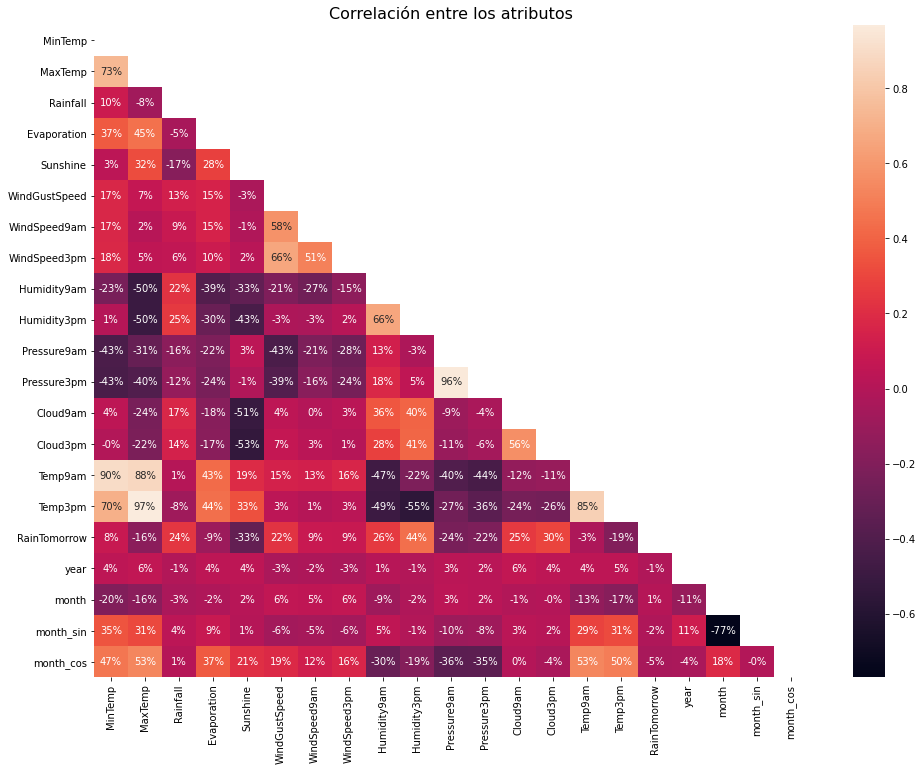

In [ ]:
df_corr = df_train.corr()

mask = np.triu(np.ones_like(df_corr, dtype=bool))

fig=plt.figure(figsize=(16,12))
axis=sns.heatmap(df_corr, mask=mask, annot=True, fmt=".0%")
_ = axis.set_title('Correlación entre los atributos', fontsize=16)

Del gráfico anterior, podemos decir que las variables que tienen un mayor impacto en nuestra variable objetivo ('RainTomorrow') son: <br>
- **Humidity3pm:** La cuál se refiere al % de humedad, y puede cobrar sentido, ya que tiene que existir agua para llover.
- **Cloud3pm:** Corresponde a la Nubosidad a las 3 pm, y con está relación nos dice que existe mayor posibilidad de que llueva entre mayor nubosidad.
- Variables como **Cloud9am** que tiene una correlación similar a **Cloud3pm**, o la pareja de variables **Pressure9am** y **Pressure3pm**, que tienen una correlación negativa similar, nos podrían permitir promediarlas para disminuir la dimensión del conjunto de datos, u otras métricas, como tasas de creciemiento o decrecimiento. 
- **Sunshine:** Es el atributo con mayor correlación negativa, lo que nos dice, es que entre más soleado este, menos probable es que llueva, lo que tiene bastante sentido con la experiencia de todo el mundo.
<br>

Ya en la sección anterior, habíamos descuerbierto existe un  porcentaje alto de datos faltantes para Cloud3pm, Cloud9am, Sunshine y Evaporation, y en este apartado fue encontrar que algunas de estas tienen una buena correlación con nuestra variable objetivo, lo cuál será interesante análizar en la fase de modelado.


Ahora, para disminuir la multicolinealidad, utilizaré un umbral de 0.7 para determinar una alta correlación entre variables.

In [ ]:
corr_threshold = 0.7
corr_cols = []

for col in df_corr.columns:
    df_tmp = df_corr[col][(abs(df_corr[col]) > corr_threshold) & (abs(df_corr[col]) < 1)]
    
    if not df_tmp.empty:
        corr_cols.append(col)
        print(col)
        print(df_tmp)
        print()

MinTemp
MaxTemp    0.734447
Temp9am    0.898541
Name: MinTemp, dtype: float64

MaxTemp
MinTemp    0.734447
Temp9am    0.880119
Temp3pm    0.968654
Name: MaxTemp, dtype: float64

Pressure9am
Pressure3pm    0.959926
Name: Pressure9am, dtype: float64

Pressure3pm
Pressure9am    0.959926
Name: Pressure3pm, dtype: float64

Temp9am
MinTemp    0.898541
MaxTemp    0.880119
Temp3pm    0.845809
Name: Temp9am, dtype: float64

Temp3pm
MaxTemp    0.968654
Temp9am    0.845809
Name: Temp3pm, dtype: float64

month
month_sin   -0.768592
Name: month, dtype: float64

month_sin
month   -0.768592
Name: month_sin, dtype: float64



Con un umbral de 0.7 de correlación, podemos encontrar fuertes correlaciones para: <br><br>
MinTemp - MaxTemp<br>
MinTemp - Temp9am<br>

MaxTemp - MinTemp<br>
MaxTemp - Temp9am<br>
MaxTemp - Temp3pm<br>

Pressure9am - Pressure3pm<br>

Temp9am - Temp3pm<br>
Temp9am - MaxTemp<br>
Temp9am - MinTemp<br>

Por lo que podemos elegir una de cada par, para evitar la multicolinearidad, además de las que tengan mayor correlación con la variable objetivo.

In [ ]:
df_corr.index

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainTomorrow', 'year', 'month', 'month_sin',
       'month_cos'],
      dtype='object')

In [ ]:
for col in corr_cols:
    print(col, df_corr.loc['RainTomorrow', col])

MinTemp 0.08328145461211445
MaxTemp -0.1602730023335473
Pressure9am -0.23537350010361374
Pressure3pm -0.21610806166279042
Temp9am -0.026166396040478077
Temp3pm -0.19201662065425218
month 0.009806958102175444
month_sin -0.0215417372632385


Entonces seleccionaré: MaxTemp y Pressuare9am

In [ ]:
# Nota: La preciptación así como muchas variable atmósfericas tienen un patrón espacial, 
# pero el atributo Localidad tiene una alta cardinalidad, por ello, creo que una forma viable 
# de usar esta información, es a través  de la clusterización para encontrar las ciudades
# con características atmósfericas más parecidas y con ello crear un modelo regional.

# Eliminación de columnas por multicolinealidad
drop_columns = ['MinTemp', 'Pressure3pm', 'Temp9am', 'Temp3pm']

**Eliminación de atributos no requerdiso por el modelo**

In [ ]:
df_train = df_train.drop(columns=['Location', 'Date', 'month', 'year'])

## 5. Valores atípicos

In [ ]:
df_train.describe(include='all')

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,month_sin,month_cos
count,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644,106644.000000,106644,106644,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644,106644.000000,1.066440e+05,1.066440e+05
unique,NaN,NaN,NaN,NaN,NaN,16,NaN,16,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,W,NaN,N,SE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,14304,NaN,16058,10950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83105,NaN,NaN,NaN
mean,12.207287,23.246297,2.325183,5.189314,8.039609,NaN,39.902939,NaN,NaN,13.995940,18.638226,68.820374,51.485588,1017.641431,1015.242757,4.644856,4.700452,17.009117,21.691251,NaN,0.224185,1.189343e-02,-1.477849e-02
std,6.383586,7.095477,8.369363,3.166367,2.778594,NaN,13.098637,NaN,NaN,8.847333,8.694669,18.924410,20.514263,6.732757,6.668432,2.293770,2.120167,6.470597,6.855390,NaN,0.417047,7.045355e-01,7.094218e-01
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,NaN,6.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,NaN,0.000000,-1.000000e+00,-1.000000e+00
25%,7.600000,18.000000,0.000000,4.000000,8.200000,NaN,31.000000,NaN,NaN,7.000000,13.000000,57.000000,37.000000,1013.500000,1011.000000,3.000000,4.000000,12.300000,16.700000,NaN,0.000000,-5.000000e-01,-8.660254e-01
50%,12.000000,22.700000,0.000000,4.800000,8.500000,NaN,39.000000,NaN,NaN,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,NaN,0.000000,1.224647e-16,-1.836970e-16
75%,16.800000,28.300000,0.600000,5.400000,8.700000,NaN,46.000000,NaN,NaN,19.000000,24.000000,83.000000,65.000000,1021.800000,1019.400000,6.000000,6.000000,21.600000,26.300000,NaN,0.000000,5.000000e-01,5.000000e-01


Podemos observar que la varible Rainfall cuenta con valores atípicos, donde la mayor cantidad de valores se encuentra cercano a 0.

Para el manejo de valores atípicos, usaré un umbral de 5 percentil, por lo que si se encuentran por debajo del percentil 5 o por encima del percentil 95, los valores serán modificados a los valores de los percentiles correspondientes.

Es buena idea disminuir la cardinalidad para los atributos: WindGustDir, WindDir9am y WindDir3pm ya que si se realiza la codificación de nuestro valores, podrías aumentar la dimensión de nuestro dataset. <br>
Podría realizar diferentes estrategias, como no incluirlas dentro del modelo, utilizar análisis de componentes principales para disminuir la dimensión o utilizar estrategias como WOE (Weight of Evidence), el cuál nos dice el poder predictivo de una varialbe independiente, además de permitirnos agrupar variables categóricas o númericas.

In [ ]:
def create_dictionary_outliers(data: pd.DataFrame,
                               threshold: float = 0.95) -> dict:
    """Returns a dictionarty with the lower and upper value get from IQR 0.5 and 0.95
    for every column in a dataframe"""
    
    outliers_dict = {}
    
    for col in get_numerical_columns(data):
        lower = data[col].quantile(1 - threshold)
        upper = data[col].quantile(threshold)
        outliers_dict[col] = {'lower': lower,
                              'upper': upper}
        
    return outliers_dict    

In [ ]:
outliers_dict = rain.create_dictionary_outliers(df_train)

In [ ]:
rain.save_to_pickle(outliers_dict, r'..\results\outliers_dict')

In [ ]:
outliers_dict = rain.load_pickle(r'..\results\outliers_dict.pickle')

**Aplicando los valores máximos y minímos a los valores atípicos**

In [ ]:
outliers_dict

{'MinTemp': {'lower': 1.8, 'upper': 23.0},
 'MaxTemp': {'lower': 12.9, 'upper': 35.5},
 'Rainfall': {'lower': 0.0, 'upper': 13.0},
 'Evaporation': {'lower': 1.2, 'upper': 10.6},
 'Sunshine': {'lower': 1.4, 'upper': 12.1},
 'WindGustSpeed': {'lower': 20.0, 'upper': 65.0},
 'WindSpeed9am': {'lower': 0.0, 'upper': 30.0},
 'WindSpeed3pm': {'lower': 6.0, 'upper': 33.0},
 'Humidity9am': {'lower': 34.0, 'upper': 98.0},
 'Humidity3pm': {'lower': 17.0, 'upper': 87.0},
 'Pressure9am': {'lower': 1006.6, 'upper': 1029.0},
 'Pressure3pm': {'lower': 1004.4, 'upper': 1026.5},
 'Cloud9am': {'lower': 0.0, 'upper': 8.0},
 'Cloud3pm': {'lower': 1.0, 'upper': 8.0},
 'Temp9am': {'lower': 7.0, 'upper': 28.2},
 'Temp3pm': {'lower': 11.6, 'upper': 33.6},
 'month_sin': {'lower': -1.0, 'upper': 1.0},
 'month_cos': {'lower': -1.0, 'upper': 1.0}}

In [ ]:
def processing_outliers(data:pd.DataFrame,
                        outliers_dict: dict) -> pd.DataFrame:
    """Converts the values under the lower value into the lower value, and
    the values above the upper value into the upper value.
    
    The lower and upper values were obtained through IQR 0.5 and 0.95"""
    
    for key in outliers_dict.keys():
        data.loc[data[key] < outliers_dict[key]['lower'], key] = outliers_dict[key]['lower'] 
        data.loc[data[key] > outliers_dict[key]['upper'], key] = outliers_dict[key]['upper'] 
        
    
    return data

In [ ]:
df_train = rain.processing_outliers(df_train, outliers_dict)

In [ ]:
df_train.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow,month_sin,month_cos
count,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,1.066440e+05,1.066440e+05
mean,12.229048,23.234973,1.505244,5.014242,8.050296,39.565104,13.723426,18.423784,69.241054,51.435505,1017.682595,1015.269711,4.644846,4.735709,17.044906,21.673565,0.224185,1.189343e-02,-1.477849e-02
std,5.993843,6.548066,3.409363,2.241904,2.586501,11.628122,8.124870,7.720660,17.696272,19.394337,6.004021,5.974593,2.293754,2.048785,6.016829,6.288855,0.417047,7.045355e-01,7.094218e-01
min,1.800000,12.900000,0.000000,1.200000,1.400000,20.000000,0.000000,6.000000,34.000000,17.000000,1006.600000,1004.400000,0.000000,1.000000,7.000000,11.600000,0.000000,-1.000000e+00,-1.000000e+00
25%,7.600000,18.000000,0.000000,4.000000,8.200000,31.000000,7.000000,13.000000,57.000000,37.000000,1013.500000,1011.000000,3.000000,4.000000,12.300000,16.700000,0.000000,-5.000000e-01,-8.660254e-01
50%,12.000000,22.700000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000,1.224647e-16,-1.836970e-16
75%,16.800000,28.300000,0.600000,5.400000,8.700000,46.000000,19.000000,24.000000,83.000000,65.000000,1021.800000,1019.400000,6.000000,6.000000,21.600000,26.300000,0.000000,5.000000e-01,5.000000e-01
max,23.000000,35.500000,13.000000,10.600000,12.100000,65.000000,30.000000,33.000000,98.000000,87.000000,1029.000000,1026.500000,8.000000,8.000000,28.200000,33.600000,1.000000,1.000000e+00,1.000000e+00


En la siguiente función retomo los pasos llevados con anterioridad para el procesamiento de la información

In [ ]:
# Para facilitar el procesamiento y poder replicarlo en el dataset de prueba, es necesario
# colocar todos los procesos realizados en una función.

def process_data(data: pd.DataFrame,
                 drop_columns: Union[list, None] = None) -> pd.DataFrame:
    """flow to process the data set to fine-tune for modeling.
    The process consists:
    - Filling with the mode for categorical missing data
    - Filling with the median for numerical missing data
    - Encoding the target
    - Dropping useless columns and attributes with multicollineartiy
    - Dealing with outliers"""

    # They're eliminated for missing data (>35%)
    # data = data.drop(
    # columns=['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am'])

    # Filling nan values with mode for categorical values
    mode_dict = load_pickle('../results/mode_dict.pickle')
    median_dict = load_pickle('../results/median_dict.pickle')

    # Filling nan values with mode for categorical values
    for col in mode_dict.keys():
        if col in data.columns:
            data[col].fillna(mode_dict[col], inplace=True)
    # Filling nan values with median for numerical values
    for col in median_dict.keys():
        if col in data.columns:
            data[col].fillna(median_dict[col], inplace=True)

    # Encoding attribute target
    data['RainTomorrow'] = encode_target(data['RainTomorrow'])

    if drop_columns:
        data = data.drop(columns=drop_columns)

    # Processing outliers
    outliers_dict = load_pickle(r'..\results\outliers_dict.pickle')
    data = processing_outliers(data, outliers_dict)

    return data